# Assignment 3

# Instructions

1. You have to use only this notebook for all your code.
2. All the results and plots should be mentioned in this notebook.
3. For final submission, submit this notebook along with the report ( usual 2-4 pages, latex typeset, which includes the challenges faces and details of additional steps, if any)
4. Marking scheme
    -  **60%**: Your code should be able to detect bounding boxes using resnet 18, correct data loading and preprocessing. Plot any 5 correct and 5 incorrect sample detections from the test set in this notebook for both the approached (1 layer and 2 layer detection), so total of 20 plots.
    -  **20%**: Use two layers (multi-scale feature maps) to detect objects independently as in SSD (https://arxiv.org/abs/1512.02325).  In this method, 1st detection will be through the last layer of Resnet18 and the 2nd detection could be through any layer before the last layer. SSD uses lower resolution layers to detect larger scale objects. 
    -  **20%**: Implement Non-maximum suppression (NMS) (should not be imported from any library) on the candidate bounding boxes.
    
5. Report AP for each of the three class and mAP score for the complete test set.

In [187]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import os
from skimage import io,transform,util
import random
from tqdm import tqdm_notebook as tqdm
import pickle as pkl
from PIL import Image
from torch.optim import lr_scheduler
import matplotlib.patches as patches
import cv2
from mapscore import mAP 
%matplotlib inline
plt.ion()
# Import other modules if required
# Can use other libraries as well
resnet_input = 224#size of resnet18 input images

In [188]:
def random_rotation(image_array):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return transform.rotate(image_array, random_degree)

def random_noise(image_array):
    # add random noise to the image
    return util.random_noise(image_array)

def horizontal_flip(image_array):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

available_transformations = {
    'rotate': random_rotation,
    'horizontal_flip': horizontal_flip
}
available_transformations2 = {
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}

In [189]:
# Choose your hyper-parameters using validation data
batch_size = 10
num_epochs = 50
learning_rate =  0.001
hyp_momentum = 0.9
validation_split = .2
shuffle_dataset = True

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, i.e. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the three classes(aeroplane, bottle, chair). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be four. This is important for applying the sliding window method later.


In [190]:
classes = ['__background__',
           'aeroplane',
           'bottle','chair'
        ]
class_num={'__background__':0,'aeroplane':1,'bottle':2,'chair':3}

In [213]:
# Function to find the Intersection over union given the coordinates of two boxes.
# Coordinates are expected as a list of tuples of form [(x1,y1),(x2,y2)]
def IOU(cord1,cord2):
    ar1= 1.0*(cord1[1][0]-cord1[0][0])*(cord1[1][1]-cord1[0][1])#area of box1
    ar2= 1.0*(cord2[1][0]-cord2[0][0])*(cord2[1][1]-cord2[0][1])#area of box2
    x_overlap= max(0, min(cord1[1][0],cord2[1][0])-max(cord2[0][0],cord1[0][0]))
    y_overlap= max(0, min(cord1[1][1],cord2[1][1])-max(cord2[0][1],cord1[0][1]))
    intersect_area=x_overlap*y_overlap*1.0# Area of intersection
    union_area=ar1+ar2-intersect_area # Ar(box1 U box2)
    return intersect_area/union_area

# Function to find the ratio of the area of box2 covered by box1 to the area of box1
# Coordinates are expected as a list of tuples of form [(x1,y1),(x2,y2)]
def ovrlap(cord1,cord2):
    ar2= 1.0*(cord2[1][0]-cord2[0][0])*(cord2[1][1]-cord2[0][1])
    x_overlap= max(0, min(cord1[1][0],cord2[1][0])-max(cord2[0][0],cord1[0][0]))
    y_overlap= max(0, min(cord1[1][1],cord2[1][1])-max(cord2[0][1],cord1[0][1]))
    intersect_area=x_overlap*y_overlap*1.0
    return intersect_area/ar2


# The random smapling function: Takes an image and a list of boxes(lis_cord) and 
# returns a random patch with lower than threshold overlap. found by a given criteria
def random_sampler(img, lis_cord,thresh=0.1,criteria=ovrlap):
    overlap=1
    (y,x,_)= img.shape # gets image shape
    cord1=[(0,0),(0,0)]
    k=2 # the function returns a patch of size 1/k of the image
    i=1
    while overlap>thresh:
        if i is 50: # searches for a proper random patch of appr. size, if not found, increments k by 1
            i=0
            k=k+1
        i=i+1 
        xmin=random.randint(1,int((k-1)*x/k))
        ymin=random.randint(1,int((k-1)*y/k))
        xmax=xmin+int(x/k)
        ymax=ymin+int(y/k)
        overlap=0
        cord1=[(xmin,ymin),(xmax,ymax)]
        for cord2 in lis_cord:
            curr_lap=criteria(cord1,cord2)
            if curr_lap>overlap:
                overlap=curr_lap
    return cord1
# x=io.imread("VOCdevkit/VOC2007/JPEGImages/008231.jpg")
# print(random_sampler(x,[[(21,128),(55,122)],[(41,35),(123,300)]]))

In [214]:

x.shape

AttributeError: 'dict_keys' object has no attribute 'shape'

In [215]:
"""
Function to build dataset-----------------------------------------------------------------------------------------

Takes in the root_dir and build the data-set in target_dir. Works in two modes, selected by optype:
1. train:  For each images in the "images" folder, the annotation folder is searched for the xml 
            file corresponding to the image. The annotations are read using xml.tree. For each image, 
            the box is cropped, its type checked and placed in the relevant category folder in the target directory
            Then, "randnum" random samples are generated which have a low overlap with the objects.
2. test:   In test mode, the image is saved in the target_dir inside an images directory. The bounding boxes
            annotations are saved in a list of list, where each list represents a vector containing [xmin,ymin,xmax,ymax,class_label] 
            This list is then saved in an "args" folder.
"""


def build_dataset(root_dir,target_dir,optype,randnum=2,thresh=0.1,criteria=ovrlap,tf=True):
    # Begin
    img_dir=os.path.join(root_dir,"JPEGImages")
    ann_dir=os.path.join(root_dir,"Annotations")
    num_labels=0
    num_images=0
    for x in os.listdir(ann_dir):
        anpth=os.path.join(ann_dir,x)
        impth=os.path.join(img_dir,os.path.splitext(x)[0]+".jpg")
        tree=ET.parse(anpth)
        i=0
        root=tree.getroot()
        if optype=='train':
            lis_cord=[]
        elif optype=='test':
            out=[]
        image=io.imread(impth)
        width,height,_=image.shape
        trgt=os.path.join(target_dir,optype)
        for prop in root.findall('object'):
            lbl=prop.find('name').text
            xmin=int(prop.find('bndbox').find('xmin').text)
            ymin=int(prop.find('bndbox').find('ymin').text)
            xmax=int(prop.find('bndbox').find('xmax').text)
            ymax=int(prop.find('bndbox').find('ymax').text)
            if lbl in classes:
                if optype=='train':
                    save_pth=os.path.join(trgt,lbl,os.path.splitext(x)[0]+"_"+str(i)+".png")
                    crop=image[ymin:ymax,xmin:xmax]
                    io.imsave(save_pth,crop)
                    lis_cord.append([(xmin,ymin),(xmax,ymax)])
                    
                                        # random num of transformations to apply
                    num_transformations_to_apply = random.randint(1, len(available_transformations))

                    num_transformations = 0
                    transformed_image = None
                    if tf:
                        while num_transformations <= num_transformations_to_apply:
                            # choose a random transformation to apply for a single image
                            key = random.choice(list(available_transformations))
                            transformed_image = available_transformations[key](crop)
                            num_transformations += 1

                        new_file_path = os.path.join(trgt,lbl,os.path.splitext(x)[0]+"_"+str(i)+"a.png")
                        # write image to the disk
                        io.imsave(new_file_path, transformed_image)
                elif optype=='test':
                    vec=[1.0*xmin/height,1.0*ymin/width,1.0*xmax/height,1.0*ymax/width,class_num[lbl]]
                    out+=[vec]
                num_labels=num_labels+1
                print("Number of Labels = {}".format(num_labels))
                i=i+1
        if i is not 0:
            if optype=='train':
                for j in range(1,randnum+1):# random Patch generation
                    num_images=num_images+1
                    print("Number of Images is {}".format(num_images))
                    save_pth=os.path.join(trgt,"__background__",os.path.splitext(x)[0]+"_"+str(j)+".png")
                    [(xmin,ymin),(xmax,ymax)]=random_sampler(image,lis_cord,thresh,ovrlap)
                    crop=image[ymin:ymax,xmin:xmax]
                    #crop=transform.resize(crop,resnet_input)
                    io.imsave(save_pth,crop)
                    lis_cord.append([(xmin,ymin),(xmax,ymax)])

            if optype=='test':
                ims=os.path.join(trgt,"images",os.path.splitext(x)[0]+".png")
                io.imsave(ims,image)
                cords=os.path.join(trgt,"args",os.path.splitext(x)[0])
                with open(cords, 'wb') as handle:
                    pkl.dump(out, handle, protocol=pkl.HIGHEST_PROTOCOL)# save the list lists

    print("\n\n\n\nTotal Number of Images = {}\n Total Number of encompassed Labels = {}".format(num_images,num_labels))

# build_dataset("VOCdevkit/VOC2007/","Voc_dataset","test")
# build_dataset("VOCdevkit_train/VOC2007/","Voc_dataset","train")
# build_dataset("VOCdevkit/VOC2007/","Voctest","train",randnum=25,criteria=IOU,thresh=0.4,tf=False)

In [209]:
class voc_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        self.root = root_dir
        self.transform=transform
        self.ids = list()
        self.chk=train
        if train:
            for clas in os.listdir(root_dir):
                pth=os.path.join(root_dir,clas)
                for file in os.listdir(pth):
                        filpth= os.path.join(pth,file)
                        self.ids.append((filpth,class_num[clas]))
        else:
            pth=os.path.join(root_dir,"images")
            for file in os.listdir(pth):
                filpth= os.path.join(pth,file)
                argpth=os.path.join(root_dir,os.path.splitext(file)[0])
                self.ids.append((filpth,argpth))
    def __len__(self):
        # Begin
        return len(self.ids)
    def __getitem__(self, idx):
       # Begin
        if self.chk:
            (addr,clas)=self.ids[idx]
            image=io.imread(addr)
            image =Image.fromarray(image)
            if self.transform:
                image=self.transform(image)
            return (image,clas)
        else:
            (addr,arg)=self.ids[idx]
            image=io.imread(addr)
            image =Image.fromarray(image)
            if self.transform:
                image=self.transform(image)
            with open(arg, 'rb') as handle:
                out=pkl.load(handle)
            return (image,out)

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 4 classes of the VOC dataset. 

In [210]:
#Added a normalize transform
composed_transform = transforms.Compose([transforms.Resize((resnet_input,resnet_input)),
                                         transforms.RandomHorizontalFlip(),#random flipping
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])



train_dataset = voc_dataset(root_dir='Voc_dataset/train', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = voc_dataset(root_dir='Voc_dataset/test', train=False, transform=composed_transform) # Supply proper root_dir


#
random_seed= 42
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

dataset_sizes={'train':(1-validation_split) * dataset_size,'val':validation_split * dataset_size}
dataloaders={}
dataloaders['train'] = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
dataloaders['val']=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

NameError: name 'train_dataset' is not defined

### Fine-tuning
Use the pre-trained network to fine-tune the network in the following section:

In [192]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 4)

# Add code for using CUDA here
model=resnet18.cuda()

In [10]:
criterion = nn.CrossEntropyLoss(torch.rand(4).cuda())
# Update if any errors occur
optimizer = optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)
#A Scheduler to tume learning rates on the go.
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3) 

fol='Aug_weight'

In [29]:
#One Layer Detection
def train():
    # Begin
    best_model_wts = model.state_dict() # Contains the best model weights
    best_acc = 0.0
    i=0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
                i+=1
            else:
                model.eval() # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for data in tqdm(dataloaders[phase]):
                # get the inputs
                inputs, labels = data
                inputs = inputs.cuda()
                labels = labels.cuda()
                # zero the parameter gradients
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase== 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.data.item()
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val':
                #Learn a model only if the accurracy increases
                if epoch_acc >= best_acc :
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                else:
                    model.load_state_dict(best_model_wts)
            if i != 0 and phase=='train':#Save each model
                print('Saving state, iter:', i)
                torch.save(model.state_dict(), fol+'/Resnet18' +
                           repr(i) + '.pth')
    return

In [30]:
%time train()

Epoch 0/49
----------



train Loss: 0.0378 Acc: 0.7118
Saving state, iter: 1



val Loss: 0.0220 Acc: 0.7712
Epoch 1/49
----------



train Loss: 0.0214 Acc: 0.8044
Saving state, iter: 2



val Loss: 0.0248 Acc: 0.8218
Epoch 2/49
----------



train Loss: 0.0150 Acc: 0.8527
Saving state, iter: 3



val Loss: 0.0129 Acc: 0.8821
Epoch 3/49
----------



train Loss: 0.0103 Acc: 0.8868
Saving state, iter: 4



val Loss: 0.0104 Acc: 0.8608
Epoch 4/49
----------



train Loss: 0.0070 Acc: 0.9006
Saving state, iter: 5



val Loss: 0.0104 Acc: 0.9026
Epoch 5/49
----------



train Loss: 0.0069 Acc: 0.9105
Saving state, iter: 6



val Loss: 0.0086 Acc: 0.9122
Epoch 6/49
----------



train Loss: 0.0066 Acc: 0.9103
Saving state, iter: 7



val Loss: 0.0102 Acc: 0.8923
Epoch 7/49
----------



train Loss: 0.0078 Acc: 0.9079
Saving state, iter: 8



val Loss: 0.0151 Acc: 0.8967
Epoch 8/49
----------



train Loss: 0.0054 Acc: 0.9191
Saving state, iter: 9



val Loss: 0.0089 Acc: 0.9092
Epoch 9/49
----------



train Loss: 0.0055 Acc: 0.9274
Saving state, iter: 10



val Loss: 0.0083 Acc: 0.9173
Epoch 10/49
----------



train Loss: 0.0030 Acc: 0.9408
Saving state, iter: 11



val Loss: 0.0087 Acc: 0.9224
Epoch 11/49
----------



train Loss: 0.0026 Acc: 0.9470
Saving state, iter: 12



val Loss: 0.0078 Acc: 0.9357
Epoch 12/49
----------



train Loss: 0.0018 Acc: 0.9562
Saving state, iter: 13



val Loss: 0.0058 Acc: 0.9474
Epoch 13/49
----------



train Loss: 0.0018 Acc: 0.9527
Saving state, iter: 14



val Loss: 0.0079 Acc: 0.9386
Epoch 14/49
----------



train Loss: 0.0028 Acc: 0.9559
Saving state, iter: 15



val Loss: 0.0061 Acc: 0.9570
Epoch 15/49
----------



train Loss: 0.0017 Acc: 0.9599
Saving state, iter: 16



val Loss: 0.0065 Acc: 0.9379
Epoch 16/49
----------



train Loss: 0.0019 Acc: 0.9553
Saving state, iter: 17



val Loss: 0.0057 Acc: 0.9474
Epoch 17/49
----------



train Loss: 0.0016 Acc: 0.9582
Saving state, iter: 18



val Loss: 0.0056 Acc: 0.9459
Epoch 18/49
----------



train Loss: 0.0015 Acc: 0.9647
Saving state, iter: 19



val Loss: 0.0071 Acc: 0.9548
Epoch 19/49
----------



train Loss: 0.0014 Acc: 0.9636
Saving state, iter: 20



val Loss: 0.0064 Acc: 0.9379
Epoch 20/49
----------



train Loss: 0.0012 Acc: 0.9628
Saving state, iter: 21



val Loss: 0.0073 Acc: 0.9548
Epoch 21/49
----------



train Loss: 0.0013 Acc: 0.9649
Saving state, iter: 22



val Loss: 0.0076 Acc: 0.9283
Epoch 22/49
----------



train Loss: 0.0013 Acc: 0.9663
Saving state, iter: 23



val Loss: 0.0055 Acc: 0.9592
Epoch 23/49
----------



train Loss: 0.0018 Acc: 0.9652
Saving state, iter: 24



val Loss: 0.0061 Acc: 0.9452
Epoch 24/49
----------



train Loss: 0.0011 Acc: 0.9685
Saving state, iter: 25



val Loss: 0.0061 Acc: 0.9555
Epoch 25/49
----------



train Loss: 0.0011 Acc: 0.9707
Saving state, iter: 26



val Loss: 0.0057 Acc: 0.9555
Epoch 26/49
----------



train Loss: 0.0012 Acc: 0.9641
Saving state, iter: 27



val Loss: 0.0065 Acc: 0.9481
Epoch 27/49
----------



train Loss: 0.0012 Acc: 0.9682
Saving state, iter: 28



val Loss: 0.0074 Acc: 0.9467
Epoch 28/49
----------



train Loss: 0.0014 Acc: 0.9731
Saving state, iter: 29



val Loss: 0.0059 Acc: 0.9555
Epoch 29/49
----------



train Loss: 0.0019 Acc: 0.9702
Saving state, iter: 30



val Loss: 0.0076 Acc: 0.9540
Epoch 30/49
----------



train Loss: 0.0012 Acc: 0.9702
Saving state, iter: 31



val Loss: 0.0057 Acc: 0.9540
Epoch 31/49
----------



train Loss: 0.0012 Acc: 0.9689
Saving state, iter: 32



val Loss: 0.0054 Acc: 0.9555
Epoch 32/49
----------



train Loss: 0.0018 Acc: 0.9667
Saving state, iter: 33



val Loss: 0.0055 Acc: 0.9467
Epoch 33/49
----------



train Loss: 0.0011 Acc: 0.9700
Saving state, iter: 34



val Loss: 0.0066 Acc: 0.9430
Epoch 34/49
----------



train Loss: 0.0009 Acc: 0.9718
Saving state, iter: 35



val Loss: 0.0059 Acc: 0.9548
Epoch 35/49
----------



train Loss: 0.0011 Acc: 0.9696
Saving state, iter: 36



val Loss: 0.0059 Acc: 0.9562
Epoch 36/49
----------



train Loss: 0.0011 Acc: 0.9680
Saving state, iter: 37



val Loss: 0.0065 Acc: 0.9570
Epoch 37/49
----------



train Loss: 0.0011 Acc: 0.9689
Saving state, iter: 38



val Loss: 0.0060 Acc: 0.9562
Epoch 38/49
----------



train Loss: 0.0011 Acc: 0.9704
Saving state, iter: 39



val Loss: 0.0071 Acc: 0.9489
Epoch 39/49
----------



train Loss: 0.0009 Acc: 0.9717
Saving state, iter: 40



val Loss: 0.0062 Acc: 0.9584
Epoch 40/49
----------



train Loss: 0.0010 Acc: 0.9709
Saving state, iter: 41



val Loss: 0.0065 Acc: 0.9533
Epoch 41/49
----------



train Loss: 0.0008 Acc: 0.9735
Saving state, iter: 42



val Loss: 0.0082 Acc: 0.9570
Epoch 42/49
----------



train Loss: 0.0011 Acc: 0.9707
Saving state, iter: 43



val Loss: 0.0064 Acc: 0.9570
Epoch 43/49
----------



train Loss: 0.0010 Acc: 0.9722
Saving state, iter: 44



val Loss: 0.0057 Acc: 0.9540
Epoch 44/49
----------



train Loss: 0.0010 Acc: 0.9715
Saving state, iter: 45



val Loss: 0.0053 Acc: 0.9636
Epoch 45/49
----------



train Loss: 0.0012 Acc: 0.9715
Saving state, iter: 46



val Loss: 0.0064 Acc: 0.9467
Epoch 46/49
----------



train Loss: 0.0014 Acc: 0.9682
Saving state, iter: 47



val Loss: 0.0067 Acc: 0.9562
Epoch 47/49
----------



train Loss: 0.0013 Acc: 0.9715
Saving state, iter: 48



val Loss: 0.0072 Acc: 0.9606
Epoch 48/49
----------



train Loss: 0.0010 Acc: 0.9705
Saving state, iter: 49



val Loss: 0.0059 Acc: 0.9540
Epoch 49/49
----------



train Loss: 0.0016 Acc: 0.9715
Saving state, iter: 50



val Loss: 0.0052 Acc: 0.9606
CPU times: user 2h 1min 29s, sys: 14min 7s, total: 2h 15min 36s
Wall time: 1h 7min 48s


OrderedDict([('conv1.weight',
              tensor([[[[-1.5906e-02, -8.5674e-03, -2.5546e-03,  ...,  5.9869e-02,
                          2.1500e-02, -7.4957e-03],
                        [ 1.1431e-02,  9.5500e-03, -1.0969e-01,  ..., -2.6569e-01,
                         -1.2390e-01,  8.3139e-03],
                        [-5.4577e-03,  5.9861e-02,  2.9619e-01,  ...,  5.2137e-01,
                          2.5710e-01,  6.6679e-02],
                        ...,
                        [-2.6524e-02,  1.5491e-02,  6.9696e-02,  ..., -3.3958e-01,
                         -4.2617e-01, -2.5741e-01],
                        [ 3.5277e-02,  4.3573e-02,  6.2804e-02,  ...,  4.0987e-01,
                          3.9345e-01,  1.6784e-01],
                        [-1.0372e-02, -2.8769e-03, -2.5516e-02,  ..., -1.5911e-01,
                         -8.5668e-02, -5.9632e-03]],
              
                       [[-1.2590e-02, -2.4701e-02, -3.0620e-02,  ...,  4.1261e-02,
                          1.2216

In [25]:
#To generate confusion_matrix
confusion_matrix = torch.zeros(4, 4)
with torch.no_grad():
    model.eval()
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.cuda()
        classes = classes.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1 # Updating the matrix appropriately

RuntimeError: CUDA out of memory. Tried to allocate 30.62 MiB (GPU 0; 3.95 GiB total capacity; 2.79 GiB already allocated; 25.38 MiB free; 168.93 MiB cached)

In [ ]:
print(confusion_matrix)

In [ ]:
print(confusion_matrix.diag()/confusion_matrix.sum(1)) # Print precision scores
print(confusion_matrix.diag()/confusion_matrix.sum(0)) # Print recall scores

tensor([0.0339, 0.0000, 0.0038, 0.0000])


In [8]:
# #Was used to find correct and incorrect predictions
# nb_classes = 4
# device='cuda'
# confusion_matrix = torch.zeros(nb_classes, nb_classes)
# model.eval()
# with torch.no_grad():
#     k=0
#     j=0
#     for data in tqdm(dataloaders['val']):
#         (inputs, clas)=data
#         inputs = inputs.to(device)
#         clas = clas.to(device)
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
# #         if i==15:
# #             break
#         for t, p in zip(clas.view(-1), preds.view(-1)):
#                 confusion_matrix[t.long(), p.long()] += 1
#         for i in range(len(outputs)):
#             j+=1
#             print("At image "+str(j))
#             if preds[i] != clas[i]:
#                 print(k)
#                 k=k+1
#                 x,y,z=inputs[i].shape
# #                 torchvision.utils.save_image(inputs[i], "Failed/"+classes[preds[i]]+"/"+classes[clas[i]]+"/"+str(k)+".jpg")
#                 print("Confusing "+ classes[clas[i]] + " with "+classes[preds[i]])
#                 #print(type(tensor_image), tensor_image.shape)
#             if preds[i]==clas[i]:
#                 torchvision.utils.save_image(inputs[i], "Img/"+str(j)+".jpg")
                

In [9]:
"""
Old model with poop accurracy
"""

# class MyModel_old(nn.Module):
# #Inspired by the pytorch implementation of resnet
#     def __init__(self, o_model=models.resnet18(pretrained=True), num_classes=4, zero_init_residual=False):
#         super(ResNet18, self).__init__()
#         self.inplanes = 64
#         self.conv1 =o_model.conv1
#         self.bn1 = o_model.bn1
#         self.relu = o_model.relu
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = o_model.layer1
#         self.layer2 = o_model.layer2
#         self.layer3 = o_model.layer3
#         self.layer4 = o_model.layer4
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         #self.fc = o_model.fc
#         self.fc = nn.Linear(512, num_classes)
#         self.fc2 = nn.Linear(256, num_classes)
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         y = x # Taking output of 3rd layer
#         x = self.layer4(x)
#         x = self.avgpool(x)
#         y = self.avgpool(y)
#         y = y.view(y.size(0),-1)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         aux =x.fc2(y)
#         return x,aux

"""
Code for training the above model

"""
    
# #Two Layer Detection (SSD)
# def train():
#     #Begin
#     best_model_wts = modeli.state_dict()
#     best_acc = 0.0
#     i=0
#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 scheduler.step()
#                 modeli.train(True)  # Set model to training mode
#                 i+=1
#             else:
#                 modeli.eval() # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects1 = 0
#             running_corrects2 = 0

#             # Iterate over data.
#             for data in tqdm(dataloaders[phase]):
#                 # get the inputs
#                 inputs, labels = data
#                 inputs = inputs.cuda()
#                 labels = labels.cuda()
#                 # zero the parameter gradients
#                 optimizer.zero_grad()
#                 with torch.set_grad_enabled(phase== 'train'):
#                     outputs = modeli(inputs)
#                     output1,output2 = outputs
#                     _,preds1 = torch.max(output1,1)
#                     #_,preds2 = torch.max(output2,1)
#                     loss=criterion(output1,labels)+0.6*criterion(output2,labels)
#                 # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()
#                 # statistics
#                 running_loss += loss.data.item()
#                 running_corrects1 += torch.sum(preds1 == labels.data)
#                 running_corrects2 += torch.sum(preds2 == labels.data)
#                 #print(preds[1].data.item())
#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc1 = running_corrects1.double() / dataset_sizes[phase]
#             epoch_acc2 = running_corrects2.double() / dataset_sizes[phase]

#             print('{} Loss: {:.4f}  Acc1: {:.4f} Acc2: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc1,epoch_acc2))

#             # deep copy the model
#             if phase == 'val' and epoch_acc1+epoch_acc2 >= best_acc :
#                 best_acc = epoch_acc1+epoch_acc2
#                 best_model_wts = modeli.state_dict()
#             #model.load_state_dict(best_model_wts)
#             if i != 0 and phase=='train':
#                 print('Saving state, iter:', i)
#                 torch.save(modeli.state_dict(), 'wettwo/Resnet18' +
#                            repr(i) + '.pth')
#     return best_model_wts

In [16]:
class MyModel(nn.Module):
#Inspired by the pytorch implementation of resnet
    def __init__(self, o_model=models.resnet18(pretrained=True), num_classes=4, zero_init_residual=False):
        super(ResNet18, self).__init__()
        self.inplanes = 64
        self.conv1 =o_model.conv1
        self.bn1 = o_model.bn1
        self.relu = o_model.relu
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = o_model.layer1
        self.layer2 = o_model.layer2
        self.layer3 = o_model.layer3
        self.layer4 = o_model.layer4
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc = o_model.fc
        self.fc = nn.Linear(256+512, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        y = x # Taking output of 3rd layer
        x = self.layer4(x)
        x = self.avgpool(x)
        y = self.avgpool(y)
        y = y.view(y.size(0),-1)
        x = x.view(x.size(0), -1)
        z = torch.cat((y,x),1) #Linear feature map
        z = self.fc(z)
        return z

In [ ]:
model=MyModel().cuda()

In [ ]:
criterion = nn.CrossEntropyLoss(torch.tensor([0.5,0.5,0.5,0.5]).cuda())
# Update if any errors occur
optimizer = optim.SGD(model.parameters(), learning_rate, hyp_momentum)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
#Two Layer Detection (SSD)
def train():
    # Begin
    best_model_wts = model.state_dict() # Contains the best model weights
    best_acc = 0.0
    i=0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
                i+=1
            else:
                model.eval() # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for data in tqdm(dataloaders[phase]):
                # get the inputs
                inputs, labels = data
                inputs = inputs.cuda()
                labels = labels.cuda()
                # zero the parameter gradients
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase== 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.data.item()
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val':
                #Learn a model only if the accurracy increases
                if epoch_acc >= best_acc :
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                else:
                    model.load_state_dict(best_model_wts)
            if i != 0 and phase=='train':#Save each model
                print('Saving state, iter:', i)
                torch.save(model.state_dict(), fol+'/Resnet18' +
                           repr(i) + '.pth')
    return

In [17]:
train()

Epoch 0/69
----------



train Loss: 0.0415 Acc: 0.7522
Saving state, iter: 1



val Loss: 0.0180 Acc: 0.8975
Epoch 1/69
----------



train Loss: 0.0208 Acc: 0.8809
Saving state, iter: 2



val Loss: 0.0137 Acc: 0.9313
Epoch 2/69
----------



train Loss: 0.0178 Acc: 0.8999
Saving state, iter: 3



val Loss: 0.0116 Acc: 0.9202
Epoch 3/69
----------



train Loss: 0.0122 Acc: 0.9302
Saving state, iter: 4



val Loss: 0.0135 Acc: 0.9481
Epoch 4/69
----------



train Loss: 0.0108 Acc: 0.9399
Saving state, iter: 5



val Loss: 0.0098 Acc: 0.9239
Epoch 5/69
----------



train Loss: 0.0086 Acc: 0.9537
Saving state, iter: 6



val Loss: 0.0088 Acc: 0.9650
Epoch 6/69
----------



train Loss: 0.0075 Acc: 0.9582
Saving state, iter: 7



val Loss: 0.0113 Acc: 0.9085
Epoch 7/69
----------



train Loss: 0.0070 Acc: 0.9632
Saving state, iter: 8



val Loss: 0.0080 Acc: 0.9606
Epoch 8/69
----------



train Loss: 0.0054 Acc: 0.9693
Saving state, iter: 9



val Loss: 0.0063 Acc: 0.9694
Epoch 9/69
----------



train Loss: 0.0054 Acc: 0.9709
Saving state, iter: 10



val Loss: 0.0071 Acc: 0.9621
Epoch 10/69
----------



train Loss: 0.0049 Acc: 0.9740
Saving state, iter: 11



val Loss: 0.0083 Acc: 0.9592
Epoch 11/69
----------



train Loss: 0.0034 Acc: 0.9795
Saving state, iter: 12



val Loss: 0.0101 Acc: 0.9694
Epoch 12/69
----------



train Loss: 0.0031 Acc: 0.9843
Saving state, iter: 13



val Loss: 0.0088 Acc: 0.9658
Epoch 13/69
----------



train Loss: 0.0027 Acc: 0.9885
Saving state, iter: 14



val Loss: 0.0061 Acc: 0.9650
Epoch 14/69
----------



train Loss: 0.0021 Acc: 0.9906
Saving state, iter: 15



val Loss: 0.0067 Acc: 0.9687
Epoch 15/69
----------



train Loss: 0.0028 Acc: 0.9885
Saving state, iter: 16



val Loss: 0.0070 Acc: 0.9599
Epoch 16/69
----------



train Loss: 0.0020 Acc: 0.9918
Saving state, iter: 17



val Loss: 0.0079 Acc: 0.9717
Epoch 17/69
----------



train Loss: 0.0019 Acc: 0.9911
Saving state, iter: 18



val Loss: 0.0074 Acc: 0.9739
Epoch 18/69
----------



train Loss: 0.0018 Acc: 0.9931
Saving state, iter: 19



val Loss: 0.0056 Acc: 0.9739
Epoch 19/69
----------



train Loss: 0.0015 Acc: 0.9931
Saving state, iter: 20



val Loss: 0.0079 Acc: 0.9805
Epoch 20/69
----------



train Loss: 0.0018 Acc: 0.9920
Saving state, iter: 21



val Loss: 0.0053 Acc: 0.9746
Epoch 21/69
----------



train Loss: 0.0015 Acc: 0.9935
Saving state, iter: 22



val Loss: 0.0068 Acc: 0.9717
Epoch 22/69
----------



train Loss: 0.0016 Acc: 0.9935
Saving state, iter: 23



val Loss: 0.0061 Acc: 0.9790
Epoch 23/69
----------



train Loss: 0.0015 Acc: 0.9924
Saving state, iter: 24



val Loss: 0.0070 Acc: 0.9783
Epoch 24/69
----------



train Loss: 0.0013 Acc: 0.9957
Saving state, iter: 25



val Loss: 0.0060 Acc: 0.9672
Epoch 25/69
----------



train Loss: 0.0012 Acc: 0.9964
Saving state, iter: 26



val Loss: 0.0061 Acc: 0.9665
Epoch 26/69
----------



train Loss: 0.0009 Acc: 0.9972
Saving state, iter: 27



val Loss: 0.0057 Acc: 0.9753
Epoch 27/69
----------



train Loss: 0.0012 Acc: 0.9953
Saving state, iter: 28



val Loss: 0.0056 Acc: 0.9702
Epoch 28/69
----------



train Loss: 0.0010 Acc: 0.9953
Saving state, iter: 29



val Loss: 0.0055 Acc: 0.9753
Epoch 29/69
----------



train Loss: 0.0011 Acc: 0.9964
Saving state, iter: 30



val Loss: 0.0051 Acc: 0.9717
Epoch 30/69
----------



train Loss: 0.0015 Acc: 0.9944
Saving state, iter: 31



val Loss: 0.0057 Acc: 0.9761
Epoch 31/69
----------



train Loss: 0.0010 Acc: 0.9966
Saving state, iter: 32



val Loss: 0.0055 Acc: 0.9643
Epoch 32/69
----------



train Loss: 0.0009 Acc: 0.9972
Saving state, iter: 33



val Loss: 0.0056 Acc: 0.9709
Epoch 33/69
----------



train Loss: 0.0010 Acc: 0.9953
Saving state, iter: 34



val Loss: 0.0056 Acc: 0.9731
Epoch 34/69
----------



train Loss: 0.0007 Acc: 0.9974
Saving state, iter: 35



val Loss: 0.0060 Acc: 0.9783
Epoch 35/69
----------



train Loss: 0.0008 Acc: 0.9970
Saving state, iter: 36



val Loss: 0.0057 Acc: 0.9672
Epoch 36/69
----------



train Loss: 0.0014 Acc: 0.9944
Saving state, iter: 37



val Loss: 0.0071 Acc: 0.9775
Epoch 37/69
----------



train Loss: 0.0009 Acc: 0.9963
Saving state, iter: 38



val Loss: 0.0046 Acc: 0.9680
Epoch 38/69
----------



train Loss: 0.0010 Acc: 0.9961
Saving state, iter: 39



val Loss: 0.0060 Acc: 0.9775
Epoch 39/69
----------



train Loss: 0.0009 Acc: 0.9964
Saving state, iter: 40



val Loss: 0.0053 Acc: 0.9687
Epoch 40/69
----------



train Loss: 0.0011 Acc: 0.9975
Saving state, iter: 41



val Loss: 0.0051 Acc: 0.9724
Epoch 41/69
----------



train Loss: 0.0013 Acc: 0.9955
Saving state, iter: 42



val Loss: 0.0061 Acc: 0.9775
Epoch 42/69
----------



train Loss: 0.0009 Acc: 0.9963
Saving state, iter: 43



val Loss: 0.0049 Acc: 0.9739
Epoch 43/69
----------



train Loss: 0.0008 Acc: 0.9981
Saving state, iter: 44



val Loss: 0.0053 Acc: 0.9650
Epoch 44/69
----------



train Loss: 0.0007 Acc: 0.9972
Saving state, iter: 45



val Loss: 0.0056 Acc: 0.9746
Epoch 45/69
----------



train Loss: 0.0010 Acc: 0.9964
Saving state, iter: 46



val Loss: 0.0054 Acc: 0.9724
Epoch 46/69
----------



train Loss: 0.0006 Acc: 0.9990
Saving state, iter: 47



val Loss: 0.0052 Acc: 0.9775
Epoch 47/69
----------



train Loss: 0.0007 Acc: 0.9983
Saving state, iter: 48



val Loss: 0.0062 Acc: 0.9761
Epoch 48/69
----------



train Loss: 0.0008 Acc: 0.9970
Saving state, iter: 49



val Loss: 0.0061 Acc: 0.9739
Epoch 49/69
----------



train Loss: 0.0011 Acc: 0.9968
Saving state, iter: 50



val Loss: 0.0063 Acc: 0.9739
Epoch 50/69
----------



train Loss: 0.0007 Acc: 0.9983
Saving state, iter: 51



val Loss: 0.0068 Acc: 0.9709
Epoch 51/69
----------



train Loss: 0.0007 Acc: 0.9979
Saving state, iter: 52



val Loss: 0.0063 Acc: 0.9739
Epoch 52/69
----------



train Loss: 0.0008 Acc: 0.9970
Saving state, iter: 53



val Loss: 0.0056 Acc: 0.9702
Epoch 53/69
----------



train Loss: 0.0006 Acc: 0.9981
Saving state, iter: 54



val Loss: 0.0054 Acc: 0.9709
Epoch 54/69
----------



train Loss: 0.0007 Acc: 0.9979
Saving state, iter: 55



val Loss: 0.0054 Acc: 0.9739
Epoch 55/69
----------



train Loss: 0.0010 Acc: 0.9968
Saving state, iter: 56



val Loss: 0.0060 Acc: 0.9746
Epoch 56/69
----------



train Loss: 0.0007 Acc: 0.9970
Saving state, iter: 57



val Loss: 0.0078 Acc: 0.9753
Epoch 57/69
----------



train Loss: 0.0008 Acc: 0.9977
Saving state, iter: 58



val Loss: 0.0053 Acc: 0.9717
Epoch 58/69
----------



train Loss: 0.0007 Acc: 0.9981
Saving state, iter: 59



val Loss: 0.0064 Acc: 0.9672
Epoch 59/69
----------



train Loss: 0.0008 Acc: 0.9975
Saving state, iter: 60



val Loss: 0.0050 Acc: 0.9702
Epoch 60/69
----------



train Loss: 0.0006 Acc: 0.9983
Saving state, iter: 61



val Loss: 0.0049 Acc: 0.9739
Epoch 61/69
----------



train Loss: 0.0008 Acc: 0.9977
Saving state, iter: 62



val Loss: 0.0047 Acc: 0.9761
Epoch 62/69
----------



train Loss: 0.0009 Acc: 0.9970
Saving state, iter: 63



val Loss: 0.0062 Acc: 0.9739
Epoch 63/69
----------



train Loss: 0.0010 Acc: 0.9961
Saving state, iter: 64



val Loss: 0.0056 Acc: 0.9731
Epoch 64/69
----------



train Loss: 0.0006 Acc: 0.9983
Saving state, iter: 65



val Loss: 0.0060 Acc: 0.9731
Epoch 65/69
----------



train Loss: 0.0008 Acc: 0.9975
Saving state, iter: 66



val Loss: 0.0054 Acc: 0.9746
Epoch 66/69
----------



train Loss: 0.0009 Acc: 0.9966
Saving state, iter: 67



val Loss: 0.0078 Acc: 0.9724
Epoch 67/69
----------



train Loss: 0.0009 Acc: 0.9972
Saving state, iter: 68



val Loss: 0.0076 Acc: 0.9731
Epoch 68/69
----------



train Loss: 0.0006 Acc: 0.9985
Saving state, iter: 69



val Loss: 0.0058 Acc: 0.9717
Epoch 69/69
----------



train Loss: 0.0006 Acc: 0.9979
Saving state, iter: 70



val Loss: 0.0056 Acc: 0.9665


OrderedDict([('conv1.weight',
              tensor([[[[-1.2875e-02, -2.4555e-03,  3.8985e-03,  ...,  6.3063e-02,
                          2.2507e-02, -8.6983e-03],
                        [ 7.3860e-03,  1.1108e-02, -1.0687e-01,  ..., -2.6823e-01,
                         -1.2685e-01,  5.5881e-03],
                        [-9.9349e-03,  6.1346e-02,  2.9921e-01,  ...,  5.2184e-01,
                          2.5768e-01,  6.5494e-02],
                        ...,
                        [-3.1608e-02,  1.8086e-02,  7.6319e-02,  ..., -3.3540e-01,
                         -4.2308e-01, -2.5652e-01],
                        [ 2.6818e-02,  4.2802e-02,  6.7039e-02,  ...,  4.1172e-01,
                          3.9172e-01,  1.6746e-01],
                        [-1.9516e-02, -2.7038e-03, -2.1905e-02,  ..., -1.5152e-01,
                         -8.3592e-02, -5.3588e-03]],
              
                       [[-1.2374e-02, -2.2005e-02, -2.6905e-02,  ...,  4.0564e-02,
                          7.7608

# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [193]:
PATH='final.pth'
PATH1='final.pth'

In [194]:
model = models.resnet18()
model.fc = nn.Linear(resnet18.fc.in_features, 4)
model=model.cuda()
model.load_state_dict(torch.load(PATH))


In [ ]:
model1 = models.resnet18()
model1.fc = nn.Linear(resnet18.fc.in_features, 4)
model1=model1.cuda()
model1.load_state_dict(torch.load(PATH1))


In [195]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [ ]:
model1.eval()

In [199]:
def slidingwindow(image_dir,model,step_size,threshold):
#     step_size : value of stride by which window is sliding
#     threshold : min. prob score above which we have to keep the sliding windows

    image=io.imread(image_dir)
    ycord=image.shape[0] #height of image
    xcord=image.shape[1] #width of image
    window_size_0=[int(.3*ycord),int(.5*ycord),int(.9*ycord)]    #     length of sliding window_size
    window_size_1=[int(.3*xcord),int(.5*xcord),int(.9*xcord)]   #     widths of sliding window
    image=Image.fromarray(image)       #convert to PIL image
    detections = []
    ###code for sliding window with two loops for incurring 9 different window sizes
    for i in range(0,3):
        for j in range(0,3):
            for y in range(0, ycord-window_size_0[i], step_size):
                for x in range(0, xcord-window_size_1[j], step_size):       

                    ##cropping the part of image where sliding window is present and the transroming and feeding it to the model to get the predections
                    im_window = transforms.functional.crop(image,x,y,window_size_1[j],window_size_0[i])
                    im_window = composed_transform(im_window)
                    im_window = im_window.unsqueeze(0)

                    ##to run process on CUDA
                    im_window=im_window.cuda()               
                    outputs = model(im_window)
                    if type(outputs[0][1]) == tuple:
                        outputs, _ = outputs
                    soft=nn.Sequential(nn.Softmax(dim=1))  
                    outputs=soft(outputs)                    #for class probabilty score
                    val,preds = torch.max(outputs,1)
                    outputs = outputs.cpu().detach().numpy()[0]
                    
                    if preds == 0:      ##ignoring the case when sliding window is on some class which it classify as background
                        continue
                    if val < threshold: #the probability score is not enough
                        continue
                    if val >=threshold:
                        detections.append((x/xcord, y/ycord,(x+window_size_0[i])/xcord, (y+window_size_1[j])/ycord,float(preds),float(val),float(outputs[1]),float(outputs[2]),float(outputs[3])))
#                         print(str(x)+" " + str(y)+" " + str(window_size_1[j])+" " + str(window_size_0[i]) +" " +str(preds)+" " +str(val))
                    #for freeing up memory
                    del im_window
                    del outputs
                    del soft
                    del val
                    del preds
                    torch.cuda.empty_cache()   ##clearing the cache so tha cuda memory error dosen't occur

    return detections#_fin #,list_det

In [253]:
# %time detections=slidingwindow(image_dir,model,48,0.9)

In [252]:
# print(detections)

In [254]:
# # im = np.array(Image.open("000665_1.png"), dtype=np.uint8)
# # for i in range(len(lister)):
# im = np.array(Image.open(image_dir), dtype=np.uint8)
# for detc in detections:
# # Create figure and axes
#     fig,ax = plt.subplots(1)
# # Display the image
# #     ax.imshow(im)
# # Create a Rectangle patch
#     rect = patches.Rectangle((detc[0],detc[1]),detc[2]-detc[0],detc[3]-detc[1],linewidth=1,edgecolor='r',facecolor='none')
#     # Add the patch to the Axes
#     ax.add_patch(rect)
# #         fig.savefig("box"+lister[i])
# #         plt.show()
#     ax.imshow(im)
#     print(classes[int(detc[4])])
#     plt.show()

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [255]:
def nms(boxes, overlap=0.3, top_k=200):

# boxes: (np.array) The location preds for the img
# overlap: (float) The overlap thresh for suppressing unnecessary boxes.
# top_k: (int) The Maximum number of box preds to consider.

    boxes=torch.tensor(boxes)
#     print("no.",boxes.numel())
    if boxes.numel() == 0:
        return None,0
    scores=boxes[:,5] # scores:The class predscores for the img
    
    keep = scores.new(scores.size(0)).zero_().long()
    
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    # I = I[v >= 0.01]
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    # keep = torch.Tensor()
    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        # keep.append(i)
        keep[count] = i
        count += 1
        if idx.size(0) == 1:
            break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
#         print(area[i])
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    keep_key=keep.numpy()
        
        
#         torch.cuda.empty_cache()

# The indices of the kept boxes with respect to num_priors.
    return keep_key,count

In [258]:
# for i in range(number_nms):
#         fig,ax = plt.subplots(1)

#     # Display the image
#     #     ax.imshow(im)

#     # Create a Rectangle patch
#         rect = patches.Rectangle((detections[after_nms[i]][0],detections[after_nms[i]][1]),(detections[after_nms[i]][2]-detections[after_nms[i]][0]),(detections[after_nms[i]][3]-detections[after_nms[i]][1]),linewidth=1,edgecolor='r',facecolor='none')
#         print(detections[after_nms[i]][0],detections[after_nms[i]][1],detections[after_nms[i]][2],detections[after_nms[i]][3])
#         # Add the patch to the Axes
#         ax.add_patch(rect)
#         ax.imshow(im)

#         print(classes[int(detections[after_nms[i]][4])])
#         plt.show()

In [282]:
image_dir1="000008_1.png"

In [295]:
directory="image"

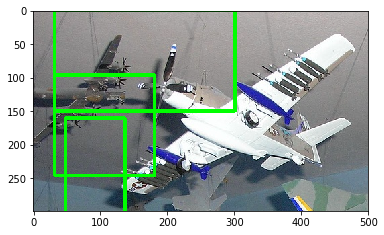

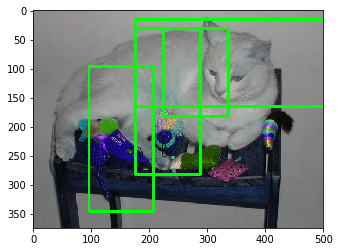

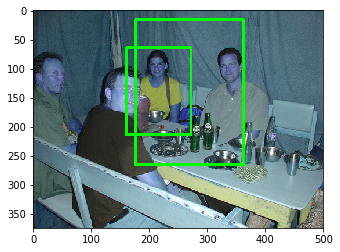

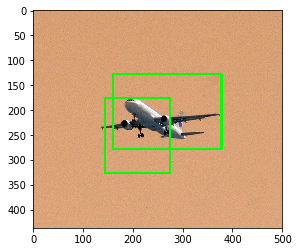

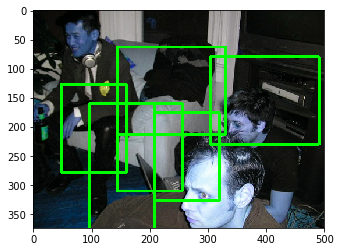

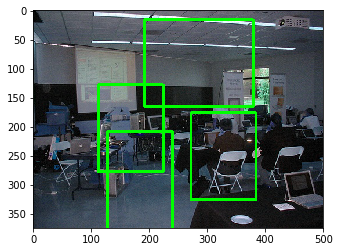

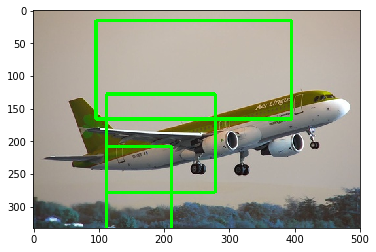

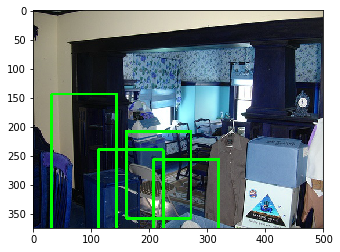

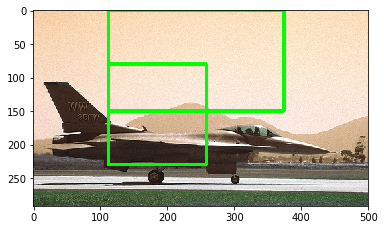

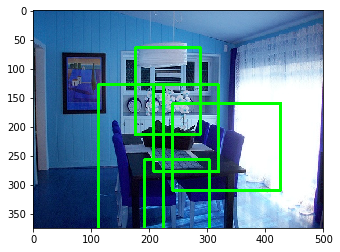

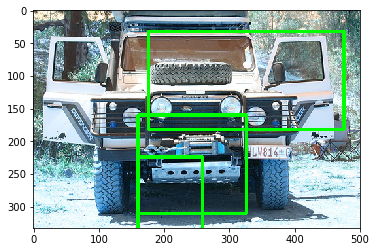

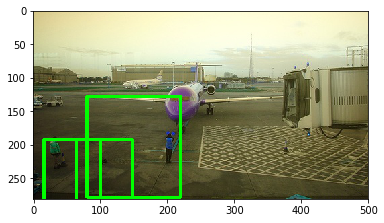

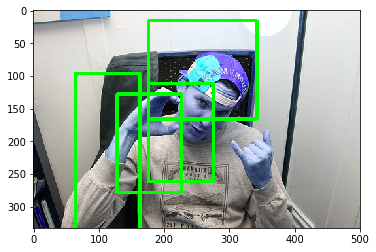

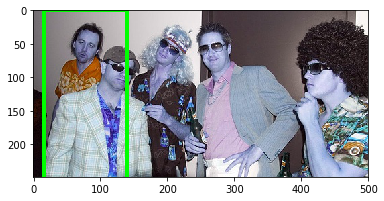

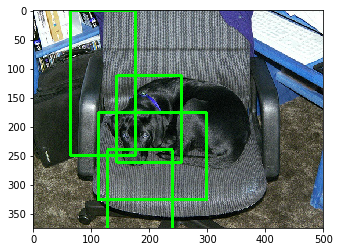

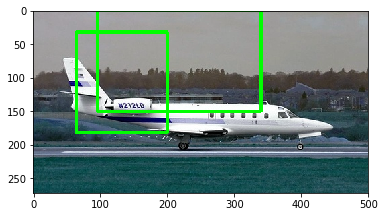

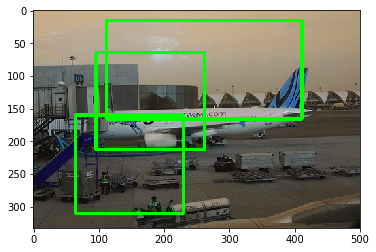

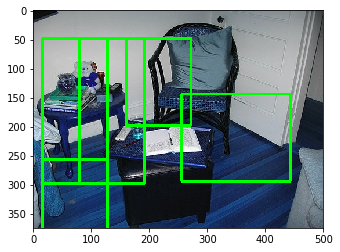

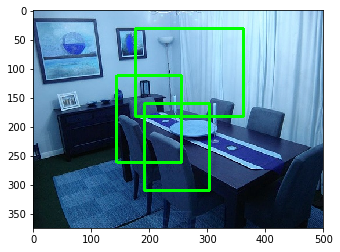

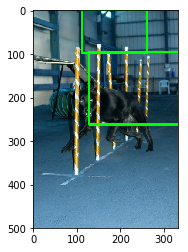

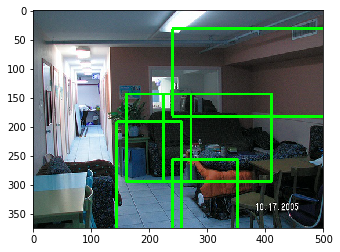

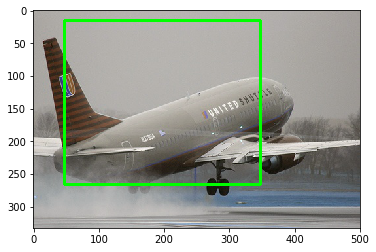

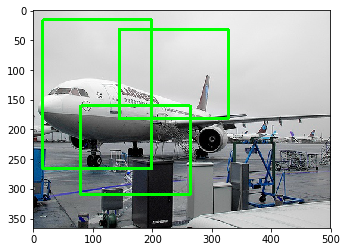

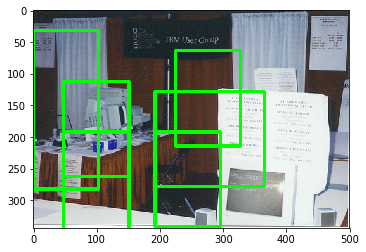

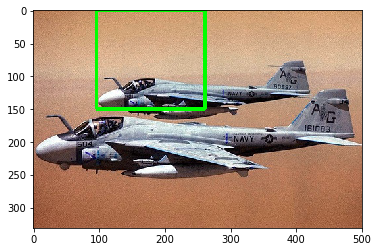

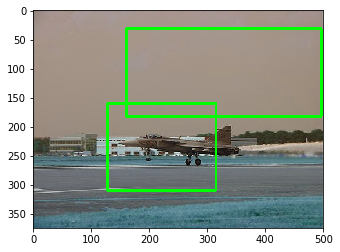

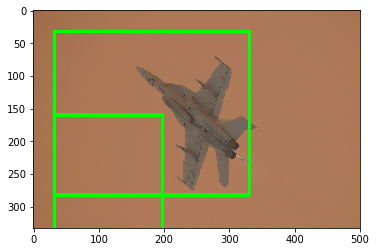

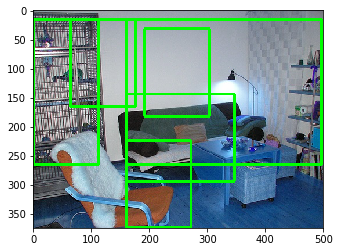

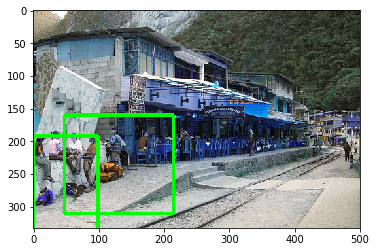

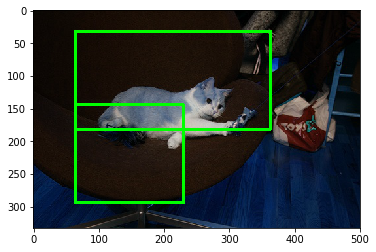

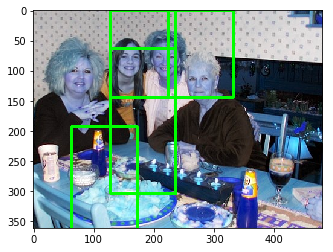

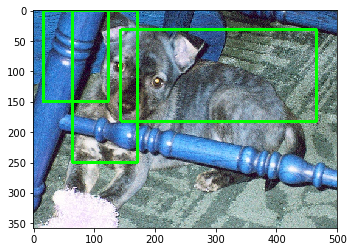

KeyboardInterrupt: 

In [306]:
for j in range(2):
#     if j%2==0:
#         print("By single layer")
#         if j==0:
#             print("correct outputs")
#         else:
#             print("Wrong outputs")
    for i in tqdm(range(len(os.listdir(directory+str(j))))):
        im = cv2.imread(directory+str(j)+"/"+os.listdir(directory+str(j))[i])
        detections=slidingwindow((directory+str(j)+"/"+os.listdir(directory+str(j))[i]),model,16,0.9)
        after_nms,number_nms=nms(detections,0.3,20)
#             print(detections)
#             print(after_nms,number_nms)
        if number_nms!=0:
            xcor=np.shape(im)[1]
            ycor=np.shape(im)[0]
            font = cv2.FONT_HERSHEY_SIMPLEX
            for ii in range(number_nms):
                x1=detections[after_nms[ii]][0]*xcor
                y1=detections[after_nms[ii]][1]*ycor
                x2=detections[after_nms[ii]][2]*xcor
                y2=detections[after_nms[ii]][3]*ycor
#                     print(x1,y1,x2,y2)
                image=cv2.rectangle(im,(int(x1),int(y1)),(int(x2),int(y2)),(0,255,0),3)

#                     cv2.putText(im,str(classes[int(detections[after_nms[ii]][4])]),(detections[after_nms[ii]][0],20+detections[after_nms[ii]][1]), font, 1,(0,0,0),1,cv2.LINE_AA)
            plt.imshow(image)
#                 plt.title(str(classes[int(detections[after_nms[i]][4])]))
            plt.show()


In [ ]:
else:
        print("By two layer")
        if j==1:
            print("correct outputs")
        else:
            print("Wrong outputs")
        for i in tqdm(range(5)):
            for i in tqdm(range(5)):
            im = cv2.imread(directory+str(j)+"/"+os.listdir(directory+str(j))[i])
            detections=slidingwindow((directory+str(j)+"/"+os.listdir(directory+str(j))[i]),model,64,0.9)
            after_nms,number_nms=nms(detections,0.3,20)
            print(detections)
            print(after_nms,number_nms)
            if number_nms!=0:
                xcor=np.shape(im)[1]
                ycor=np.shape(im)[0]
                font = cv2.FONT_HERSHEY_SIMPLEX
                for ii in range(number_nms):
                    x1=detections[after_nms[ii]][0]*xcor
                    y1=detections[after_nms[ii]][1]*ycor
                    x2=detections[after_nms[ii]][2]*xcor
                    y2=detections[after_nms[ii]][3]*ycor
                    print(x1,y1,x2,y2)
                    image=cv2.rectangle(im,(int(x1),int(y1)),(int(x2),int(y2)),(0,255,0),3)

#                     cv2.putText(im,str(classes[int(detections[after_nms[ii]][4])]),(detections[after_nms[ii]][0],20+detections[after_nms[ii]][1]), font, 1,(0,0,0),1,cv2.LINE_AA)
                plt.imshow(image)
#                 plt.title(str(classes[int(detections[after_nms[i]][4])]))
                plt.show()

Test the trained model on the test dataset.

In [241]:
direc="bhoshlu/test"
image_dir = os.listdir(direc+"/images")
an_fldr=os.path.join(direc,"args")

In [263]:
def test(model,direc="bhoshlu/test",minibach=10):
    image_dir = os.listdir(direc+"/images")
#     for i in tqdm(range(len(os.listdir(direc+"/images")))):
    savinglist_1={}
    savinglist_2={}
    savinglist_3={}
    gt_1={}
    gt_2={}
    gt_3={}
    scor = [0]*4
    map_scor=0
    #         print(scor)
    an_fldr=os.path.join(direc,"args")
    for i in tqdm(range(len(os.listdir(direc+"/images")))):
#     for i in tqdm(range(20)):
#         if i%minibach ==0:
#             savinglist_1={}
#             savinglist_2={}
#             savinglist_3={}
#             gt_1={}
#             gt_2={}
#             gt_3={}
#             scor = [0]*4
        im=io.imread(direc+"/images/"+image_dir[i])
        xcor=np.shape(im)[1]
        ycor=np.shape(im)[0]
        detections=slidingwindow(direc+"/images/"+image_dir[i],model,32,0.9)
        after_nms,number_nms=nms(detections,0.3,20)
        savinglist_1[image_dir[i]]={}
        savinglist_2[image_dir[i]]={}
        savinglist_3[image_dir[i]]={}
#         print(savinglist_1)
        savinglist_1[image_dir[i]]["boxes"]=[]
        savinglist_1[image_dir[i]]["scores"]=[]
        savinglist_2[image_dir[i]]["boxes"]=[]
        savinglist_2[image_dir[i]]["scores"]=[]
        savinglist_3[image_dir[i]]["boxes"]=[]
        savinglist_3[image_dir[i]]["scores"]=[]

        for ii in range(number_nms):
            (xmin,ymin,xmax, ymax,clas,scori,scor[1],scor[2],scor[3])=detections[ii]
#             xmin = (xmin*xcor)
#             ymin = (ymin*ycor)
#             xmax = (xmax*xcor)
#             ymax = (ymax*ycor)
            savinglist_1[image_dir[i]]["boxes"].append([xmin,ymin,xmax,ymax])
            savinglist_1[image_dir[i]]["scores"].extend([scor[1]])
            savinglist_2[image_dir[i]]["boxes"].append([xmin,ymin,xmax,ymax])
            savinglist_2[image_dir[i]]["scores"].extend([scor[2]])
            savinglist_3[image_dir[i]]["boxes"].append([xmin,ymin,xmax,ymax])
            savinglist_3[image_dir[i]]["scores"].extend([scor[3]])
            
#         print(savinglist_1)
        with open(os.path.join(an_fldr,os.path.splitext(image_dir[i])[0]), 'rb') as handle:
                an=np.array(pkl.load(handle))
#         an[:,0]=an[:,0]*xcor
#         an[:,1]=an[:,1]*ycor
#         an[:,2]=an[:,2]*xcor
#         an[:,3]=an[:,3]*ycor
        if an.size==0:
            bx = an
            k = an 
        else:
            bx = an[:,0:4]
            bx=bx.tolist()
            k = an[:,4][0]
        if k==1:
            gt_1[image_dir[i]]=bx
            gt_2[image_dir[i]]=[]
            gt_3[image_dir[i]]=[]
        if k==2:
            gt_2[image_dir[i]]=bx
            gt_1[image_dir[i]]=[]
            gt_3[image_dir[i]]=[]
        if k==3:
            gt_3[image_dir[i]]=bx
            gt_1[image_dir[i]]=[]
            gt_2[image_dir[i]]=[]

        print(i)
        if((i+1)%minibach==0):
#             print(gt_3.keys())
#             print(gt_1)
#             print(savinglist_1)
#             print(gt_2['007664.png'])
#             print(gt_2)
#             print(savinglist_2)
#             print(gt_3)
#             print(savinglist_3)
            
            mean_precs = mAP(gt_1,savinglist_2,0.3)+mAP(gt_2,savinglist_2,0.3)+mAP(gt_3,savinglist_3,0.3)
            map_scor= mean_precs + map_scor
            map_scor=map_scor/3
            print("part3")
            print(map_scor)
            mAPfile = open('mapgen3.txt',"a")
            mAPfile.write(str(map_scor)+"\n")
            mAPfile.close()

In [264]:
%time test(model,direc,3)

0
1
2
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
part3
0.0
3
4
5
[0.0455, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
part3
0.15166666666666667
6
7
8
[0.0341, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0114, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
part3
0.20222222222222222
9
10
11
[0.0248, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0248, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0682, 0.0481, 0.0481, 0.0202, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
part3
0.848074074074074
12
13
14
[0.0227, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0227, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0606, 0.0287, 0.0287, 0.0182, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
part3
0.8880246913580246
15
16
17
[0.0182, 0.0, 0.0, 0.0, 0.0, 0.0, 0

106
107
[0.0255, 0.0089, 0.0055, 0.0055, 0.0055, 0.0017, 0.0, 0.0, 0.0, 0.0]
[0.0347, 0.0234, 0.0207, 0.0104, 0.0036, 0.0014, 0.0007, 0.0007, 0.0, 0.0]
[0.0716, 0.0452, 0.0331, 0.0165, 0.0042, 0.0028, 0.0018, 0.0, 0.0, 0.0]
part3
1.5578889483226384
108
109
110
[0.028, 0.0107, 0.0071, 0.0071, 0.0071, 0.0022, 0.0009, 0.0, 0.0, 0.0]
[0.0339, 0.0229, 0.0203, 0.0102, 0.0036, 0.0014, 0.0007, 0.0007, 0.0, 0.0]
[0.0577, 0.0398, 0.0246, 0.0155, 0.0041, 0.0027, 0.0018, 0.0, 0.0, 0.0]
part3
1.5292963161075461
111
112
113
[0.0242, 0.0105, 0.007, 0.007, 0.007, 0.0021, 0.0009, 0.0, 0.0, 0.0]
[0.0332, 0.0224, 0.0198, 0.0099, 0.0035, 0.0013, 0.0007, 0.0007, 0.0, 0.0]
[0.059, 0.0453, 0.0335, 0.0152, 0.0041, 0.0027, 0.0017, 0.0, 0.0, 0.0]
part3
1.5487654387025154
114
115
116
[0.0236, 0.0102, 0.0068, 0.0068, 0.0068, 0.0021, 0.0008, 0.0, 0.0, 0.0]
[0.0327, 0.022, 0.0196, 0.0098, 0.0034, 0.0013, 0.0007, 0.0007, 0.0, 0.0]
[0.0625, 0.0483, 0.0365, 0.0181, 0.0055, 0.0034, 0.0021, 0.0, 0.0, 0.0]
part3
1.595255

[0.0422, 0.0353, 0.0302, 0.0187, 0.0111, 0.0036, 0.0011, 0.0004, 0.0, 0.0]
[0.0734, 0.0449, 0.0408, 0.0201, 0.0117, 0.0038, 0.0023, 0.0007, 0.0005, 0.0]
part3
2.0301456863562546
204
205
206
[0.0281, 0.0126, 0.0086, 0.0086, 0.0029, 0.0007, 0.0005, 0.0, 0.0, 0.0]
[0.0418, 0.035, 0.0299, 0.0185, 0.011, 0.0036, 0.0011, 0.0004, 0.0, 0.0]
[0.0744, 0.0473, 0.0406, 0.0199, 0.0112, 0.0038, 0.0023, 0.0007, 0.0005, 0.0]
part3
2.0233818954520846
207
208
209
[0.0291, 0.0126, 0.0085, 0.0085, 0.0028, 0.0007, 0.0005, 0.0, 0.0, 0.0]
[0.0414, 0.0345, 0.0295, 0.0183, 0.0109, 0.0035, 0.0011, 0.0004, 0.0, 0.0]
[0.075, 0.0482, 0.0413, 0.0204, 0.0124, 0.0037, 0.0022, 0.0007, 0.0005, 0.0]
part3
2.0301272984840284
210
211
212
[0.0289, 0.0124, 0.0084, 0.0084, 0.0028, 0.0007, 0.0005, 0.0, 0.0, 0.0]
[0.0411, 0.0343, 0.0293, 0.0182, 0.0108, 0.0035, 0.001, 0.0003, 0.0, 0.0]
[0.0756, 0.0489, 0.041, 0.0202, 0.0123, 0.0037, 0.0022, 0.0007, 0.0005, 0.0]
part3
2.02904243282801
213
214
215
[0.0322, 0.0124, 0.0083, 0.0083

KeyboardInterrupt: 

In [ ]:
%time test(resnet18)

In [ ]:
#Two Layer Detection
def test(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model

In [ ]:
%time test(resnet18)

In [ ]:
# def non_maximum_supression(boxes,threshold = 0.3):
#     tresh=0.2
#     #assuming the input format is going to be like [(image_name,boxes)]
#     #boxes = [(location,class)]
#     #location = [x1,x2,y1,y2,score]
#     aero = []
#     bottle = []
#     chair = []
#     for box in boxes:
# #         aero = []
# #         bottle = []
# #         chair = []

# #         for box in i[5]:
# #         print(box)
#         if box[4] == 1:
#             aero = aero + [box]
#         elif box[4] == 2:
#             bottle = bottle + [box]
#         else:
#             chair = chair + [box]
#     aero.sort(key=lambda x: x[5])
#     bottle.sort(key=lambda x: x[5])
#     chair.sort(key=lambda x: x[5])
#     while(len(aero)>0):
#         xintmin = aero[-1][0]
#         xintmax = aero[-1][1]
#         yintmin = aero[-1][2]
#         yintmax = aero[-1][3]
#         for i in aero:
#             #find the commonalities
#             x1 = i[0]
#             x2 = i[1]
#             y1 = i[2]
#             y2 = i[3]
#             if((x1>x_max2)or(x2<x_max1)):
#                 overlap = 1
#             if((y1>y_max2)or(y2<y_max1)):
#                 overlap = 1
#             if overlap == 0:
#                 xintmin = max(x1,x_max1)
#                 xintmax = min(x2,x_max2)
#                 yintmin = max(y1,y_max1)
#                 yintmax = min(y2,y_max2)
#                 area_int = (xintmax-xintmin)*(yintmax-yintmin)
#             else:
#                 area_int = 0
#             iou = 0
#             iou = (float(area_int))/((x2-x1)*(y2-y1)+(x_max2-x_max1)*(y_max2-y_max1)-area_int)
#             #print(iou)
#             if iou > tresh :#can change back if does not work
#                 aero.remove(i)
#                 aero_new = aero_new+[aero[-1]]
#                 aero.remove()#if this removes the last element..................................
    
#     while(len(bottle)>0):
#         xintmin = bottle[-1][0]
#         xintmax = bottle[-1][1]
#         yintmin = bottle[-1][2]
#         yintmax = bottle[-1][3]
#         for i in aero:
#             #find the commonalities
#             x1 = i[0]
#             x2 = i[1]
#             y1 = i[2]
#             y2 = i[3]
#             if((x1>x_max2)or(x2<x_max1)):
#                 overlap = 1
#             if((y1>y_max2)or(y2<y_max1)):
#                 overlap = 1
#             if overlap == 0:
#                 xintmin = max(x1,x_max1)
#                 xintmax = min(x2,x_max2)
#                 yintmin = max(y1,y_max1)
#                 yintmax = min(y2,y_max2)
#                 area_int = (xintmax-xintmin)*(yintmax-yintmin)
#             else:
#                 area_int = 0
#             iou = 0
#             iou = (float(area_int))/((x2-x1)*(y2-y1)+(x_max2-x_max1)*(y_max2-y_max1)-area_int)
#             #print(iou)
#             if iou > tresh :#can change back if does not work
#                 bottle.remove(i)
#                 bottle_new = bottle_new+[aero[-1]]
#                 bottle.remove()#if this removes the last element..................................
    
#     while(len(chair)>0):
#         xintmin = chair[-1][0]
#         xintmax = chair[-1][1]
#         yintmin = chair[-1][2]
#         yintmax = chair[-1][3]
#         for i in chair:
#             #find the commonalities
#             x1 = i[0]
#             x2 = i[1]
#             y1 = i[2]
#             y2 = i[3]
#             if((x1>x_max2)or(x2<x_max1)):
#                 overlap = 1
#             if((y1>y_max2)or(y2<y_max1)):
#                 overlap = 1
#             if overlap == 0:
#                 xintmin = max(x1,x_max1)
#                 xintmax = min(x2,x_max2)
#                 yintmin = max(y1,y_max1)
#                 yintmax = min(y2,y_max2)
#                 area_int = (xintmax-xintmin)*(yintmax-yintmin)
#             else:
#                 area_int = 0
#             iou = 0
#             iou = (float(area_int))/((x2-x1)*(y2-y1)+(x_max2-x_max1)*(y_max2-y_max1)-area_int)
#             #print(iou)
#             if iou > thresh :#can change back if does not work
#                 chair.remove(i)
#                 chair_new = chair_new+[aero[-1]]
#                 chair.remove()#if this removes the last element..................................
                
                
            
    
        
    


                

In [62]:
# def non_maximum_supression(boxes,threshold = 0.3):
#     xmin=boxes[:,0]
#     ymin=boxes[:,1]
#     xmax=boxes[:,2]
#     ymax=boxes[:,3]
#     score=boxes[:,4]
#     descend = score.argsort()[0]
#     ar = torch.mul((xmax - xmin) ,(ymax - ymin))
#     retain=list()
#     while descend.size>0:
#         i=descend[-1]
#         retain.append(i)
#         descend.pop()
#         arr=[IOU([(xmin[i],ymin[i]),(xmax[i],ymax[i])],[(xmin[descend[k]],ymin[descend[k]]),(xmax[descend[k]],ymax[descend[k]])]) for k in range(len(descend))]
#         nex=np.where(arr<=threshold)[0]
#         descend=descend[nex+1]
#     return retain